In [ ]:
library(Seurat)
library(Matrix)
library(dplyr)
library(pheatmap)
library(ggplot2)
library(tidyverse)
library(patchwork)
library(harmony)
library(readxl)
library(viridis)
library(GSVA)

options(warn = -1)
library(future)
availableCores()
options(future.globals.maxSize = 50 * 1024^4)
plan("multicore", workers = 10)

In [2]:
setwd('/data/work/02.result/others/Chen/LUSC_immune/02.result/0901/immune/GSVA')

In [3]:
obj <- readRDS('../immu_anno_0905.rds')
obj

head(obj,3)

An object of class Seurat 
39434 features across 48968 samples within 1 assay 
Active assay: RNA (39434 features, 3000 variable features)
 3 dimensional reductions calculated: pca, harmony, umap

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,doublet_info,doublet_score,name,sample,type,GEO,RNA_snn_res.0.8,seurat_clusters,Sample,RNA_snn_res.0.5,stage,sub,main,celltype_big,celltype_sub
,<chr>,<dbl>,<int>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<fct>,<fct>,<chr>,<fct>,<fct>,<fct>,<chr>,<chr>,<chr>
p018_AAACCCACAACTTGGT-1,p018,1982,843,6.861756,Singlet,0.07692308,p018,N1,Normal,CodeOcean,3,3,p018,5,normal,Macrophage,Immune Cell,Macrophage,Macrophage
p018_AAACCCACAAGAATAC-1,p018,2508,1061,10.247209,Singlet,0.30769231,p018,N1,Normal,CodeOcean,3,3,p018,2,normal,Macrophage,Immune Cell,Macrophage,Macrophage
p018_AAACCCACATCCGGCA-1,p018,2167,1070,11.952007,Singlet,0.00000000,p018,N1,Normal,CodeOcean,4,4,p018,5,normal,Macrophage,Immune Cell,Macrophage,Macrophage


In [4]:
getwd()

[1] "/data/work/02.result/others/Chen/LUSC_immune/02.result/0901/immune/GSVA"

In [5]:
redox_genes <- c("KEAP1","NFE2L2","HMOX1","NQO1","SOD1","SOD2","GPX1","GPX2","GPX5","GPX6","GPX7","GPX8","CAT",
                 "PRDX1","PRDX2","PRDX3","PRDX4","PRDX5","PRDX6","TXNRD1","TXNRD2","GCLC","GCLM","NOX1","NOX4","XDH","FOXO1","NOS2","PTGS2")
length(redox_genes)

tumor_deg_genes <- c(
  "HMOX1","HSPA1A","HSPA1B","HSP90AB1","HSPE1","HSPD1",
  "JUN","JUNB","JUND","FOS",
  "NFKBIA","TNFAIP3","TNFAIP8",
  "DDIT4","DUSP1","DUSP2","DUSP4","DUSP16",
  "BTG1","BTG2",
  "GZMA","GZMK",
  "H2AX","H2AZ1","H2AZ2",
  "IER2",
  "MT-RNR2","MT-RNR1","MTATP6P1"
)

cd8_redox_related <- c(
  "HSPA1A","HSPA1B","HSPA6","DNAJB1","HSPH1",  # 热休克蛋白家族 → 典型的氧化应激应答分子
  "GZMA","GZMB","GZMK","GZMH","PRF1","CTSW", # 细胞毒颗粒相关 → 通过ROS生成和线粒体损伤诱导氧化应激
  "IFNG","CCL3","CCL4","CCL5","XCL2",  # 炎症因子 → 激活ROS/NOS通路，上下游关联氧化应激
  "ATF3","GADD45B","NR4A2","RUNX3","HOPX",  # 转录因子/应激反应调控 → 参与氧化应激信号转导
  "H2AFZ","H3F3B","LYAR", # DNA损伤/染色质调控 → 与氧化应激导致的DNA损伤修复相关
  "LAG3","CRTAM","KLRC1","KLRC2","KLRD1","KLRG1", # 免疫受体 → 受ROS介导的T细胞功能变化和免疫耗竭影响
  "AREG" # 上皮修复因子 → 与ROS介导的组织修复调控相关
)


length(tumor_deg_genes)

all_redox_genes <- Reduce(union, list(redox_genes, tumor_deg_genes, cd8_redox_related))
length(all_redox_genes)

all_redox_genes


immune_genes <- c(
  "PDCD1","PD-1","TBX21","T-bet","EOMES","TOX","CTLA4","CD152",
  "PTPN11","PP2A","HAVCR2","TIM-3","TIMD3","CEACAM1","LAG3","CD223",
  "TIGIT","VSIG9","VSTM3","TGFBR2","TGFBR1","ALK5","SMAD2","SMAD3",
  "SMAD4","IL10","IL10RA","IL10RB","JAK1","TYK2","STAT3","ADORA2A","ADORA2B"
)

all_immune_genes <- c(
  immune_genes,
  "CTLA4",   # 已有，但保留
  "TIGIT",   # 已有，但保留
  "CD69",    # 抑制T细胞迁移，和耗竭相关
  "NFKBIA",  # 抑制 NF-κB 信号
  "TNFAIP3", # NF-κB 负调控，限制免疫活性
  "TNFAIP8", # 抑制性分子，负向调控T细胞
  "BTG1",    # 抑制增殖，促进休眠/耗竭
  "BTG2",    # 同BTG1，免疫抑制微环境常高表达
  "JUNB",    # AP-1转录因子，耗竭程序相关
  "FOS"      # 与JUN配对，调控免疫耐受
)

length(all_immune_genes)

# 导入 GMT 文件
geneSets <- list(
                  redox_genes = all_redox_genes,
                  immune_genes = all_immune_genes
)

[1] 29

[1] 29

[1] 84

[1] "KEAP1"    "NFE2L2"   "HMOX1"    "NQO1"     "SOD1"     "SOD2"    
 [7] "GPX1"     "GPX2"     "GPX5"     "GPX6"     "GPX7"     "GPX8"    
[13] "CAT"      "PRDX1"    "PRDX2"    "PRDX3"    "PRDX4"    "PRDX5"   
[19] "PRDX6"    "TXNRD1"   "TXNRD2"   "GCLC"     "GCLM"     "NOX1"    
[25] "NOX4"     "XDH"      "FOXO1"    "NOS2"     "PTGS2"    "HSPA1A"  
[31] "HSPA1B"   "HSP90AB1" "HSPE1"    "HSPD1"    "JUN"      "JUNB"    
[37] "JUND"     "FOS"      "NFKBIA"   "TNFAIP3"  "TNFAIP8"  "DDIT4"   
[43] "DUSP1"    "DUSP2"    "DUSP4"    "DUSP16"   "BTG1"     "BTG2"    
[49] "GZMA"     "GZMK"     "H2AX"     "H2AZ1"    "H2AZ2"    "IER2"    
[55] "MT-RNR2"  "MT-RNR1"  "MTATP6P1" "HSPA6"    "DNAJB1"   "HSPH1"   
[61] "GZMB"     "GZMH"     "PRF1"     "CTSW"     "IFNG"     "CCL3"    
[67] "CCL4"     "CCL5"     "XCL2"     "ATF3"     "GADD45B"  "NR4A2"   
[73] "RUNX3"    "HOPX"     "H2AFZ"    "H3F3B"    "LYAR"     "LAG3"    
[79] "CRTAM"    "KLRC1"    "KLRC2"    "KLRD1"    "KLRG1"    "AREG"

[1] 43

## GSVA main

In [6]:
as_matrix <- function(mat){
  tmp <- matrix(data=0L, nrow = mat@Dim[1], ncol = mat@Dim[2])
  row_pos <- mat@i+1
  col_pos <- findInterval(seq(mat@x)-1,mat@p[-1])+1
  val <- mat@x
  
  for (i in seq_along(val)){
    tmp[row_pos[i],col_pos[i]] <- val[i]
  }
  
  row.names(tmp) <- mat@Dimnames[[1]]
  colnames(tmp) <- mat@Dimnames[[2]]
  return(tmp)
}

# 获取总的细胞数量
total_cells <- ncol(obj)
batch_size <- 20000  # 每次处理6万个细胞
num_batches <- ceiling(total_cells / batch_size)  # 计算批次数量

# 存储所有 GSVA 结果的列表
all_gsva_results <- list()

# 逐批进行 GSVA 分析
for (batch in 1:num_batches) {
    
  print(paste0('=== 当前batch: ', batch, ' === '))
  start_cell <- (batch - 1) * batch_size + 1
  end_cell <- min(batch * batch_size, total_cells)
  
  # 获取当前批次的细胞名称
  batch_cells <- colnames(obj)[start_cell:end_cell]
  
  # 提取当前批次细胞的表达矩阵（直接通过列索引）
  df.data <- GetAssayData(obj, slot = "data")[, batch_cells]
  
  # 将稀疏矩阵转换为普通矩阵
  df.data1 = as_matrix(df.data)
  
  # 运行 GSVA 分析
  gsvaResult <- gsva(df.data1, 
                     geneSets,
                     method = "ssgsea",
                     ssgsea.norm = TRUE,
                     min.sz = 1, 
                     max.sz = 5000, 
                     verbose = TRUE,
                     parallel.sz = 4)
  
  # 将当前批次的 GSVA 结果存入列表
  all_gsva_results[[batch]] <- gsvaResult
}

# 合并所有 GSVA 结果
gsva_combined <- do.call(cbind, all_gsva_results)
# 获取转置后的ssGSEA得分矩阵
gsva_scores_matrix <- t(gsva_combined)
head(gsva_scores_matrix)

[1] "=== 当前batch: 1 === "
Setting parallel calculations through a MulticoreParam back-end
with workers=4 and tasks=100.
Estimating ssGSEA scores for 2 gene sets.
[1] "Calculating ranks..."
[1] "Calculating absolute values from ranks..."
  |======================================================================| 100%

[1] "Normalizing..."
[1] "=== 当前batch: 2 === "
Setting parallel calculations through a MulticoreParam back-end
with workers=4 and tasks=100.
Estimating ssGSEA scores for 2 gene sets.
[1] "Calculating ranks..."
[1] "Calculating absolute values from ranks..."
  |======================================================================| 100%

[1] "Normalizing..."
[1] "=== 当前batch: 3 === "
Setting parallel calculations through a MulticoreParam back-end
with workers=4 and tasks=100.
Estimating ssGSEA scores for 2 gene sets.
[1] "Calculating ranks..."
[1] "Calculating absolute values from ranks..."
  |======================================================================| 100%

[1] 

,redox_genes,immune_genes
p018_AAACCCACAACTTGGT-1,1.279736,1.488401
p018_AAACCCACAAGAATAC-1,1.394471,1.579279
p018_AAACCCACATCCGGCA-1,1.337762,1.588569
p018_AAACCCACATGATCTG-1,1.357079,1.526639
p018_AAACCCAGTAGTCGTT-1,1.280493,1.601572
p018_AAACCCATCAAGTCGT-1,1.320047,1.606761


In [7]:
colnames(obj@meta.data)
head(obj,3)

[1] "orig.ident"      "nCount_RNA"      "nFeature_RNA"    "percent.mt"     
 [5] "doublet_info"    "doublet_score"   "name"            "sample"         
 [9] "type"            "GEO"             "RNA_snn_res.0.8" "seurat_clusters"
[13] "Sample"          "RNA_snn_res.0.5" "stage"           "sub"            
[17] "main"            "celltype_big"    "celltype_sub"

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,doublet_info,doublet_score,name,sample,type,GEO,RNA_snn_res.0.8,seurat_clusters,Sample,RNA_snn_res.0.5,stage,sub,main,celltype_big,celltype_sub
,<chr>,<dbl>,<int>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<fct>,<fct>,<chr>,<fct>,<fct>,<fct>,<chr>,<chr>,<chr>
p018_AAACCCACAACTTGGT-1,p018,1982,843,6.861756,Singlet,0.07692308,p018,N1,Normal,CodeOcean,3,3,p018,5,normal,Macrophage,Immune Cell,Macrophage,Macrophage
p018_AAACCCACAAGAATAC-1,p018,2508,1061,10.247209,Singlet,0.30769231,p018,N1,Normal,CodeOcean,3,3,p018,2,normal,Macrophage,Immune Cell,Macrophage,Macrophage
p018_AAACCCACATCCGGCA-1,p018,2167,1070,11.952007,Singlet,0.00000000,p018,N1,Normal,CodeOcean,4,4,p018,5,normal,Macrophage,Immune Cell,Macrophage,Macrophage


In [ ]:
# # 找出名字里是 redox_genes 的列
# cols_to_remove <- grep("^(redox_genes|immune_genes)$", colnames(obj@meta.data))
# cols_to_remove
# # 删除这些列
# obj@meta.data <- obj@meta.data[, -cols_to_remove]
# colnames(obj@meta.data)
# head(obj,3)

In [8]:
# 使用cbind将多列数据添加到 meta.data 中
obj@meta.data <- cbind(obj@meta.data, gsva_scores_matrix)
colnames(obj@meta.data)

head(obj,3)

[1] "orig.ident"      "nCount_RNA"      "nFeature_RNA"    "percent.mt"     
 [5] "doublet_info"    "doublet_score"   "name"            "sample"         
 [9] "type"            "GEO"             "RNA_snn_res.0.8" "seurat_clusters"
[13] "Sample"          "RNA_snn_res.0.5" "stage"           "sub"            
[17] "main"            "celltype_big"    "celltype_sub"    "redox_genes"    
[21] "immune_genes"

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,doublet_info,doublet_score,name,sample,type,GEO,⋯,seurat_clusters,Sample,RNA_snn_res.0.5,stage,sub,main,celltype_big,celltype_sub,redox_genes,immune_genes
,<chr>,<dbl>,<int>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,⋯,<fct>,<chr>,<fct>,<fct>,<fct>,<chr>,<chr>,<chr>,<dbl>,<dbl>
p018_AAACCCACAACTTGGT-1,p018,1982,843,6.861756,Singlet,0.07692308,p018,N1,Normal,CodeOcean,⋯,3,p018,5,normal,Macrophage,Immune Cell,Macrophage,Macrophage,1.279736,1.488401
p018_AAACCCACAAGAATAC-1,p018,2508,1061,10.247209,Singlet,0.30769231,p018,N1,Normal,CodeOcean,⋯,3,p018,2,normal,Macrophage,Immune Cell,Macrophage,Macrophage,1.394471,1.579279
p018_AAACCCACATCCGGCA-1,p018,2167,1070,11.952007,Singlet,0.00000000,p018,N1,Normal,CodeOcean,⋯,4,p018,5,normal,Macrophage,Immune Cell,Macrophage,Macrophage,1.337762,1.588569


In [9]:
table(obj$type)

table(obj$celltype_big)


Normal  Tumor 
 22126  26842 


        B cell     CD4 T cell     CD8 T cell Dendritic cell     Macrophage 
          1839           8947          10983           1697          19146 
     Mast cell     Neutrophil        NK cell    Plasma cell 
           994            272           3630           1460 

In [10]:
# row.names = TRUE：确保将数据框的行名作为第一列保存到CSV文件中
write.csv(obj@meta.data, file = "GSVA_metadata_0905.csv", row.names = TRUE)

print("Metadata 已成功保存到seurat_metadata.csv文件。")

[1] "Metadata 已成功保存到seurat_metadata.csv文件。"


## 2.plot

### 2.1 type plot

In [15]:
table(obj$sample)
table(obj$Sample)


  E1   E2   E3   E4   M1   M2   M3   M4   N1   N2   N3   N4 
1569 4000  677  898 5233 7364 3833 3268 9078 5324 4499 3225 


  E1   E2   E3   E4   M1   M2   M3   M4 p018 p027 p028 p029 
1569 4000  677  898 5233 7364 3833 3268 9078 5324 4499 3225 

In [13]:
table(obj$sample,obj$type)

    
     Normal Tumor
  E1      0  1569
  E2      0  4000
  E3      0   677
  E4      0   898
  M1      0  5233
  M2      0  7364
  M3      0  3833
  M4      0  3268
  N1   9078     0
  N2   5324     0
  N3   4499     0
  N4   3225     0

In [12]:
table(obj$celltype_big,obj$type)

                
                 Normal Tumor
  B cell            333  1506
  CD4 T cell       4121  7144
  CD8 T cell        885  7780
  Dendritic cell    652  1045
  Macrophage      12995  6151
  Mast cell         511   483
  Neutrophil          0   272
  NK cell          2552  1078
  Plasma cell        77  1383

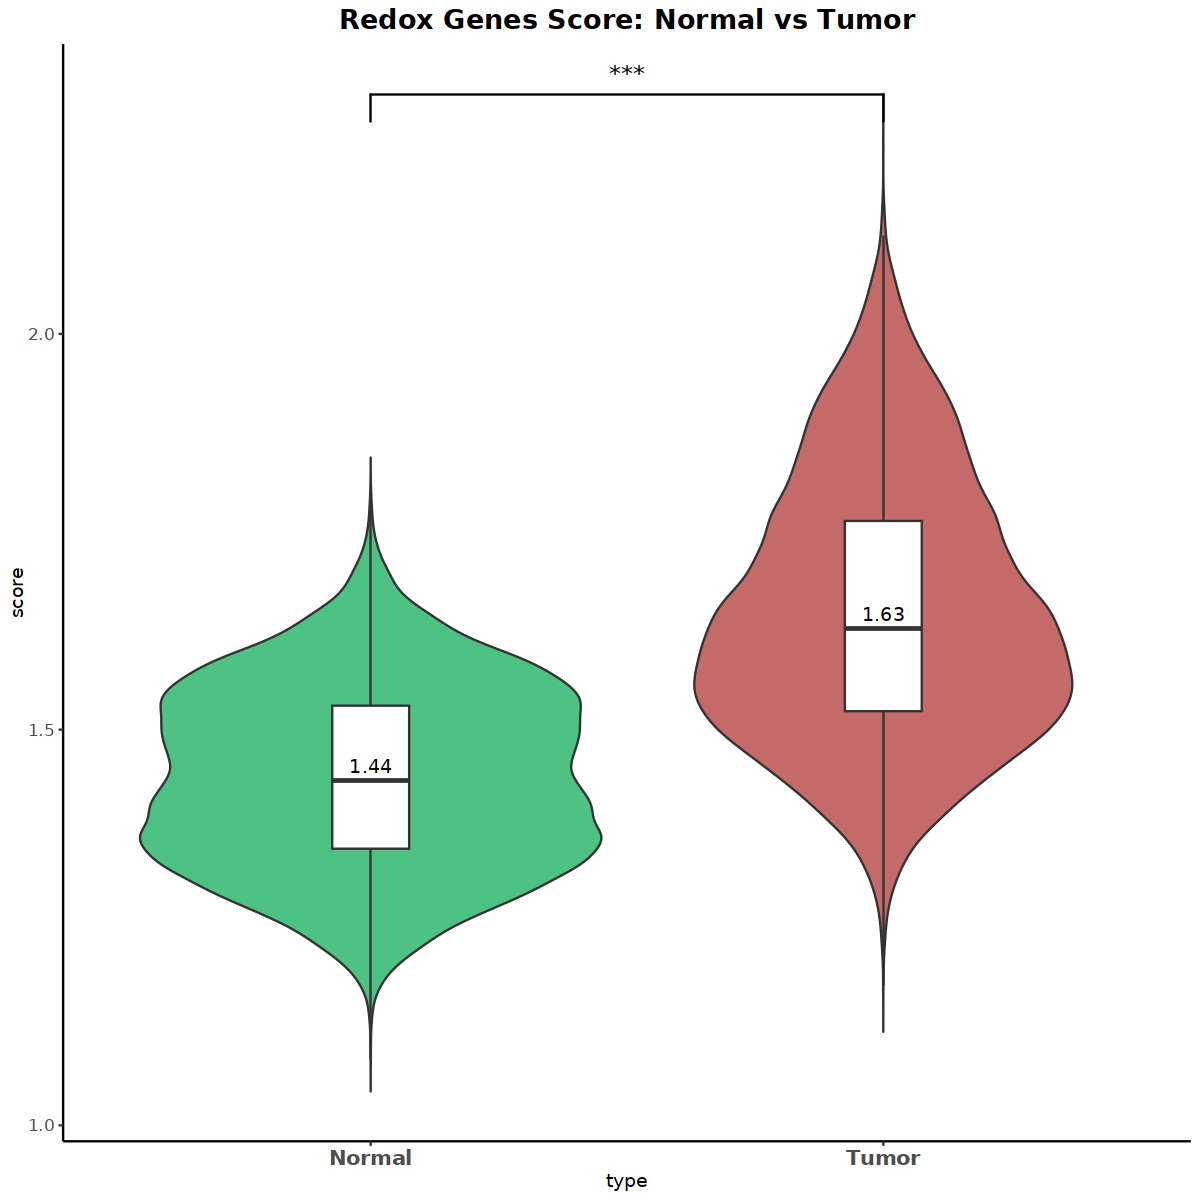

In [11]:
# (1) redox_genes

library(ggplot2)
library(dplyr)
library(ggsignif)  # 用于添加比较标注，如果没有就 install.packages("ggsignif")

options(repr.plot.width=10, repr.plot.height=10)

# 提取 meta.data 中的 score 和类型
df <- obj@meta.data[, c("redox_genes", "type")]
colnames(df) <- c("score", "type")  # 统一列名

# 确保 type 是因子，并指定顺序
df$type <- factor(df$type, levels = c("Normal", "Tumor"))

# 定义颜色
my_colors <- c("Tumor" = "#aa2a29", "Normal" = "#00A84E")

# 画小提琴 + 箱线
p <- ggplot(df, aes(x = type, y = score, fill = type)) +
  geom_violin(trim = FALSE, alpha = 0.7) +
  geom_boxplot(width = 0.15, outlier.shape = NA, fill = "white") +
  
  # 添加中位数
  stat_summary(fun = median, geom = "text", aes(label = round(..y..,2)),
               vjust = -0.5, color = "black", size = 4) +
  
  # 添加两两比较（Wilcoxon）
  geom_signif(comparisons = list(c("Normal", "Tumor")),
              test = "wilcox.test",
              step_increase = 0.1, map_signif_level = TRUE, textsize = 5) +
  
  scale_fill_manual(values = my_colors) +
  ggtitle("Redox Genes Score: Normal vs Tumor") +
  theme_classic() +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold", size = 16),
    axis.text.x = element_text(face = "bold", size = 12),
    axis.text.y = element_text(size = 10),
    legend.position = "none"
  )

p

# 保存
ggsave("RedoxGenes_VlnPlot_Normal_vs_Tumor_0905.png", plot = p, width = 8, height = 8)

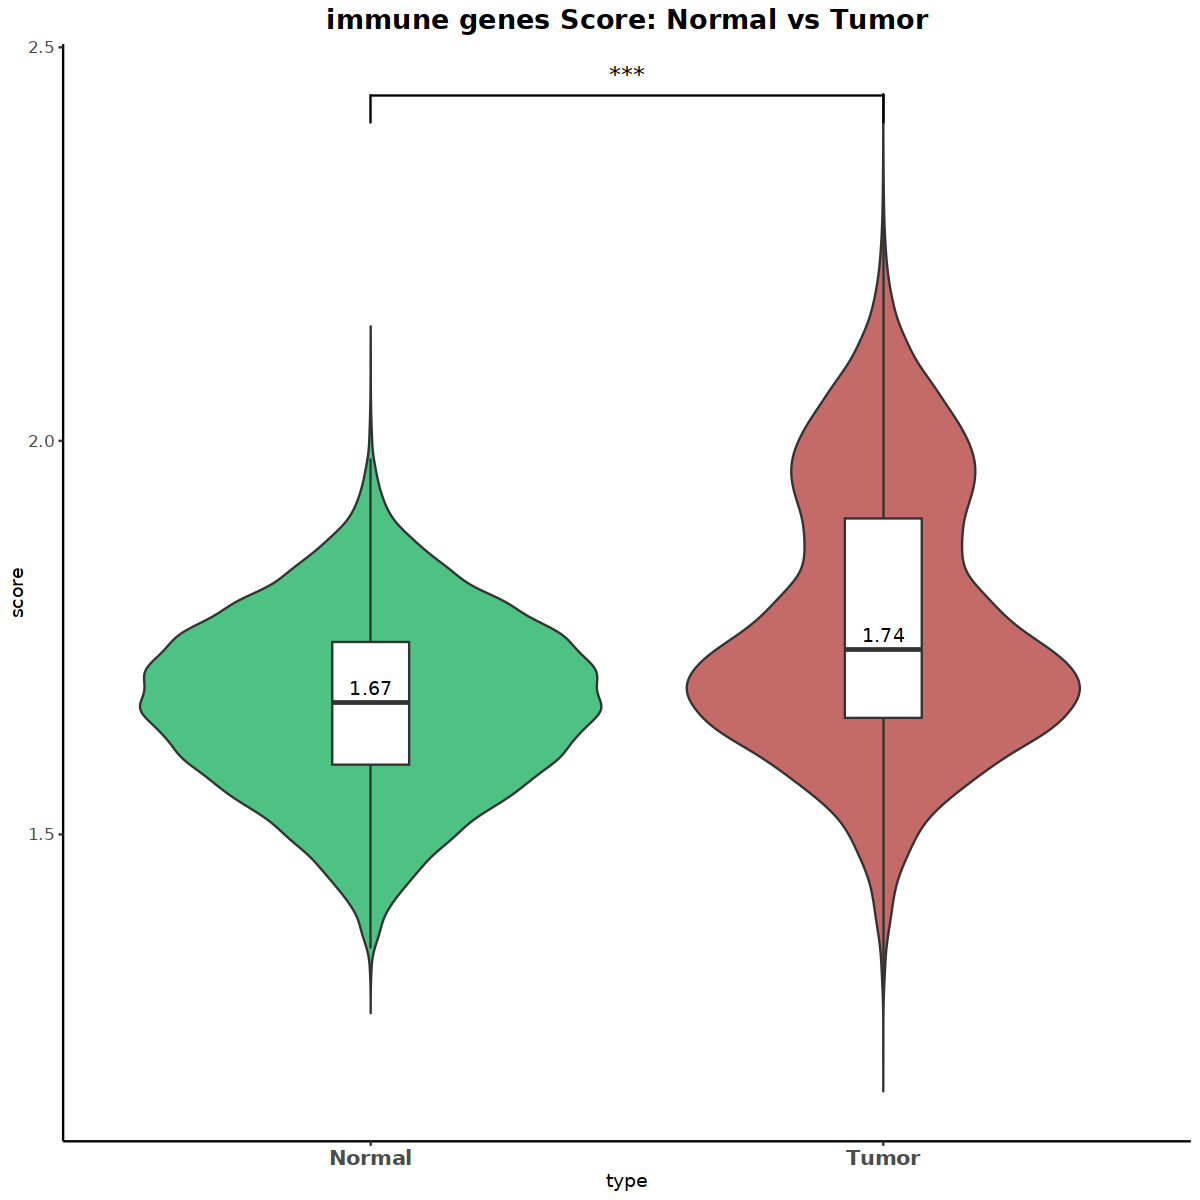

In [12]:
# (2) immune_genes

library(ggplot2)
library(dplyr)
library(ggsignif)  # 用于添加比较标注，如果没有就 install.packages("ggsignif")

options(repr.plot.width=10, repr.plot.height=10)

# 提取 meta.data 中的 score 和类型
df <- obj@meta.data[, c("immune_genes", "type")]
colnames(df) <- c("score", "type")  # 统一列名

# 确保 type 是因子，并指定顺序
df$type <- factor(df$type, levels = c("Normal", "Tumor"))

# 定义颜色
my_colors <- c("Tumor" = "#aa2a29", "Normal" = "#00A84E")

# 画小提琴 + 箱线
p <- ggplot(df, aes(x = type, y = score, fill = type)) +
  geom_violin(trim = FALSE, alpha = 0.7) +
  geom_boxplot(width = 0.15, outlier.shape = NA, fill = "white") +
  
  # 添加中位数
  stat_summary(fun = median, geom = "text", aes(label = round(..y..,2)),
               vjust = -0.5, color = "black", size = 4) +
  
  # 添加两两比较（Wilcoxon）
  geom_signif(comparisons = list(c("Normal", "Tumor")),
              test = "wilcox.test",
              step_increase = 0.1, map_signif_level = TRUE, textsize = 5) +
  
  scale_fill_manual(values = my_colors) +
  ggtitle("immune genes Score: Normal vs Tumor") +
  theme_classic() +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold", size = 16),
    axis.text.x = element_text(face = "bold", size = 12),
    axis.text.y = element_text(size = 10),
    legend.position = "none"
  )

p

# 保存
ggsave("immune_genes_VlnPlot_Normal_vs_Tumor_0905.png", plot = p, width = 8, height = 8)

### 2.2 celltype plot

In [25]:
obj

An object of class Seurat 
39434 features across 48968 samples within 1 assay 
Active assay: RNA (39434 features, 3000 variable features)
 3 dimensional reductions calculated: pca, harmony, umap

In [14]:
colnames(obj@meta.data)

table(obj$celltype_big)

[1] "orig.ident"      "nCount_RNA"      "nFeature_RNA"    "percent.mt"     
 [5] "doublet_info"    "doublet_score"   "name"            "sample"         
 [9] "type"            "GEO"             "RNA_snn_res.0.8" "seurat_clusters"
[13] "Sample"          "RNA_snn_res.0.5" "stage"           "sub"            
[17] "main"            "celltype_big"    "celltype_sub"    "redox_genes"    
[21] "immune_genes"


        B cell     CD4 T cell     CD8 T cell Dendritic cell     Macrophage 
          1839          11265           8665           1697          19146 
     Mast cell     Neutrophil        NK cell    Plasma cell 
           994            272           3630           1460 

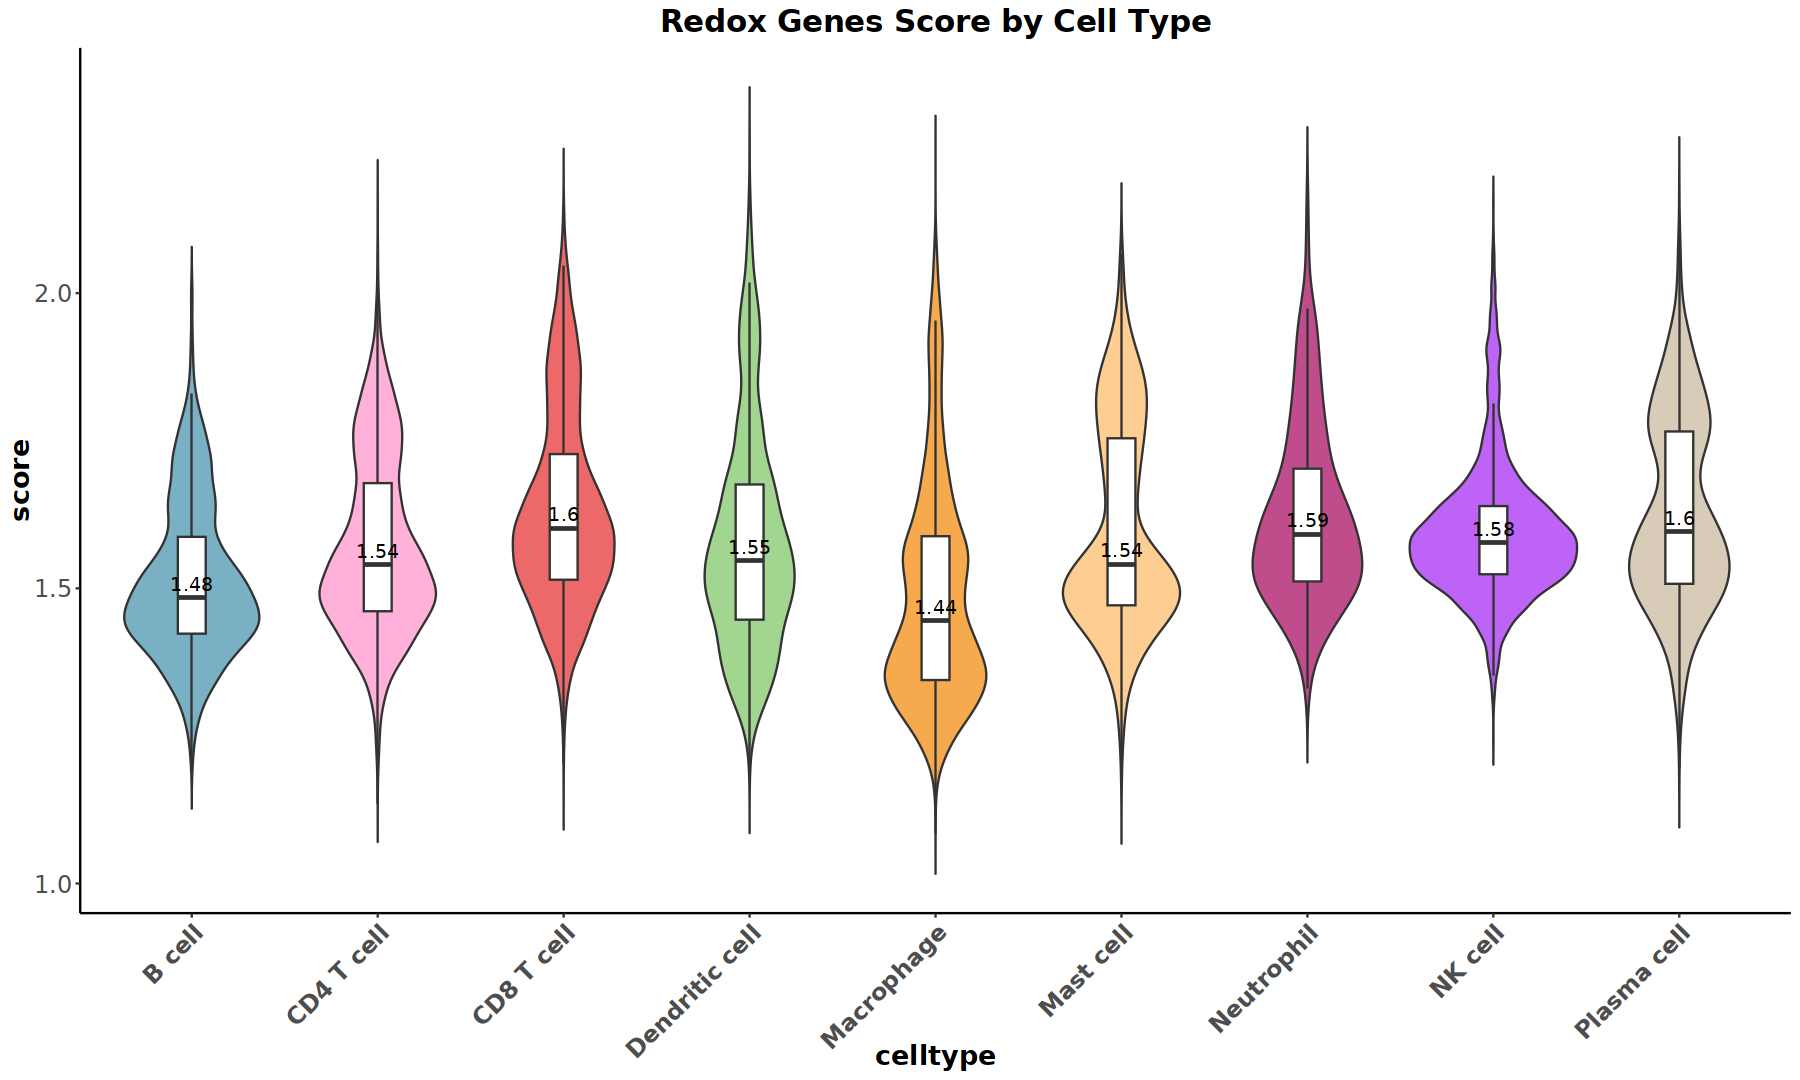

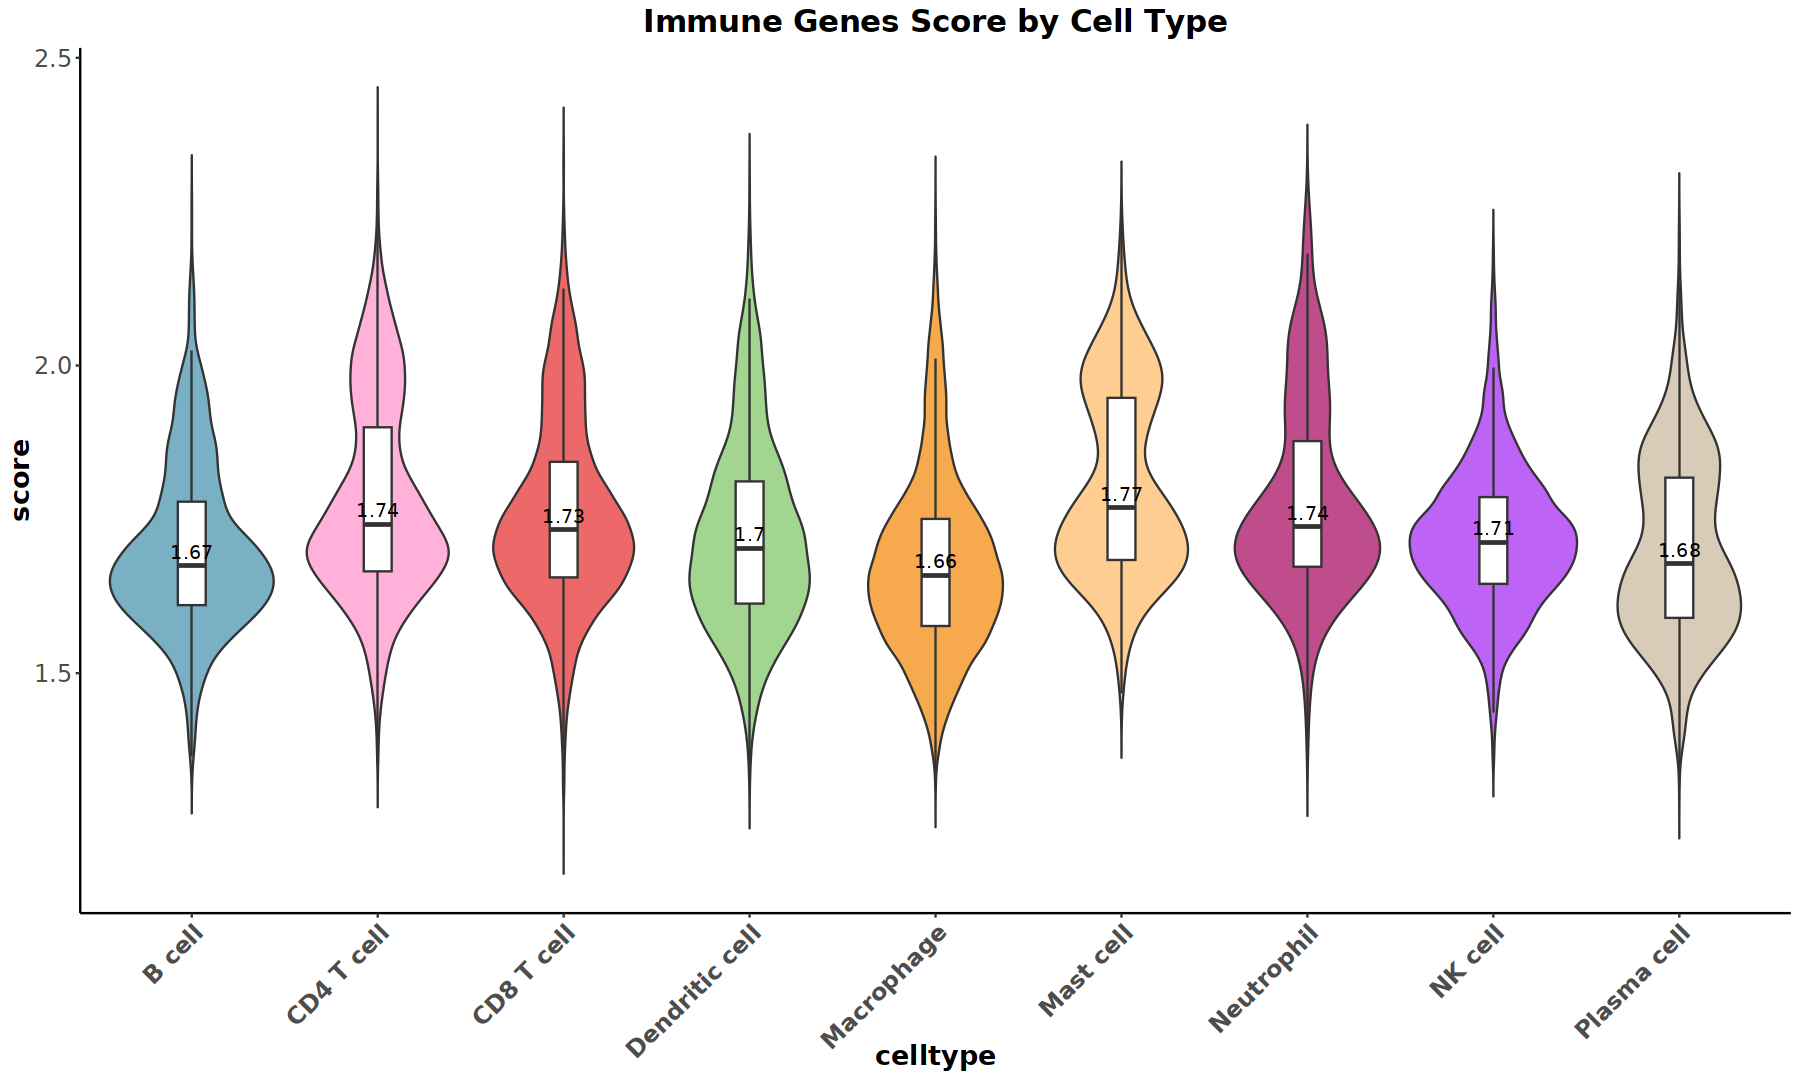

In [14]:
options(repr.plot.width=15, repr.plot.height=9)

library(ggplot2)
library(dplyr)

# 定义配色
celltype_colors <- c(
  "Macrophage"         = "#F38400",
  "Dendritic cell"     = "#79C360",
  "Mast cell"          = "#FDB762",
  "CD8 T cell"         = "#E52829",
  #"Regulatory T cell"  = "#9471B4",
  "NK cell"            = "#A020F0",
  "B cell"             = "#3F8EAA",
  "Plasma cell"        = "#c7b699",
  "CD4 T cell"         = "#FF90C9",
  "Neutrophil"         = "#A30059"
)

plot_violin_no_stats <- function(score_col, title){
  df <- obj@meta.data[, c(score_col, "celltype_big")]
  colnames(df) <- c("score", "celltype")
  df$celltype <- factor(df$celltype, levels = names(table(obj$celltype_big)))
  
  p <- ggplot(df, aes(x = celltype, y = score, fill = celltype)) +
    geom_violin(trim = FALSE, alpha = 0.7) +
    geom_boxplot(width = 0.15, outlier.shape = NA, fill = "white") +
    stat_summary(fun = median, geom = "text", aes(label = round(..y..,2)),
                 vjust = -0.5, color = "black", size = 4) +
    scale_fill_manual(values = celltype_colors) +
    ggtitle(title) +
    theme_classic() +
    theme(
      plot.title = element_text(hjust = 0.5, face = "bold", size = 18),
      axis.text.x = element_text(angle = 45, hjust = 1, size = 14, face = "bold"),
      axis.text.y = element_text(size = 14),
      axis.title.x = element_text(size = 16, face = "bold"),
      axis.title.y = element_text(size = 16, face = "bold"),
      legend.position = "none"
    )
  
  return(p)
}

# 绘图
p1 <- plot_violin_no_stats("redox_genes", "Redox Genes Score by Cell Type")
p2 <- plot_violin_no_stats("immune_genes", "Immune Genes Score by Cell Type")

# 打印
print(p1)
print(p2)

# 保存
ggsave("RedoxGenes_VlnPlot_CellType_0905.png", p1, width = 14, height = 8)
ggsave("ImmuneGenes_VlnPlot_CellType_0905.png", p2, width = 14, height = 8)


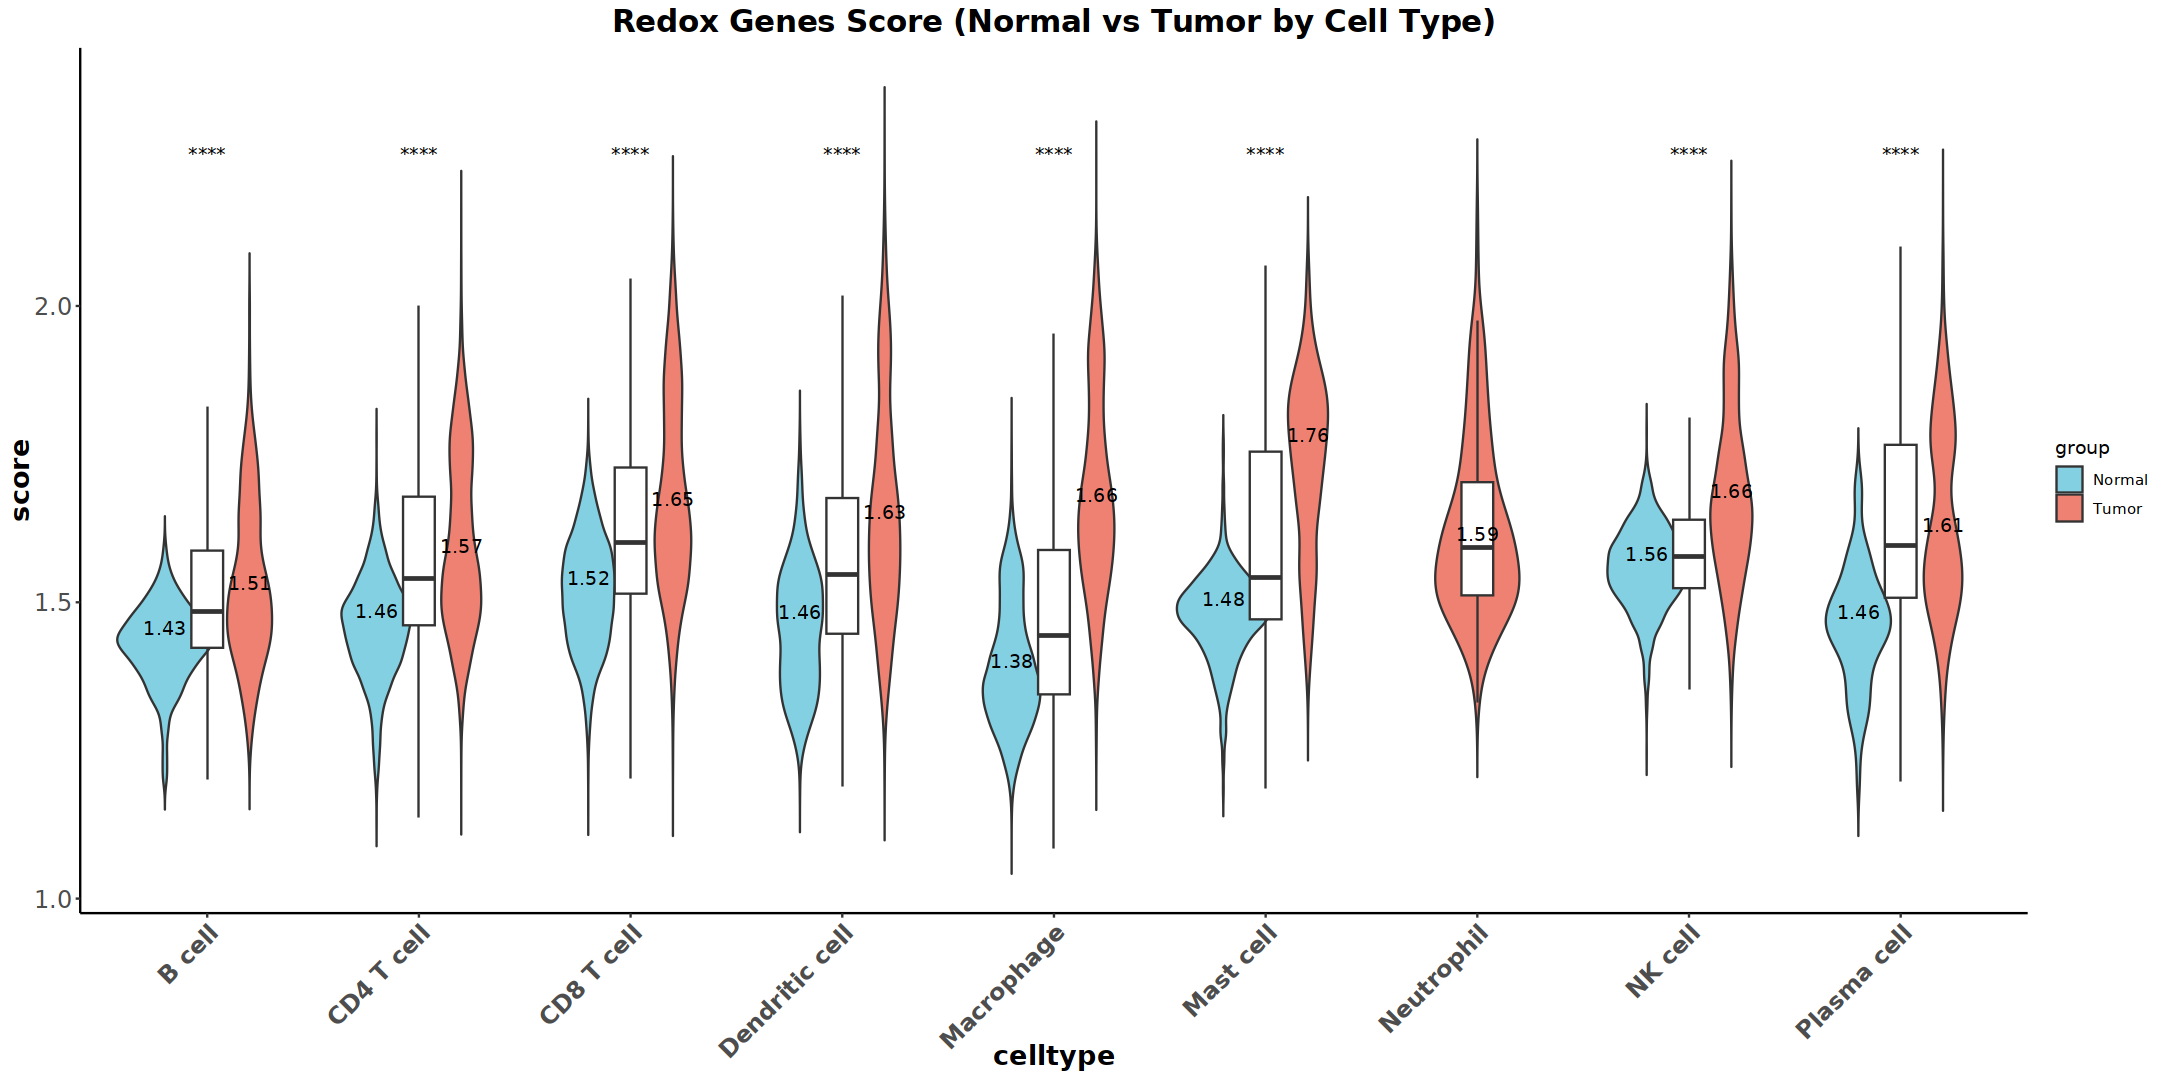

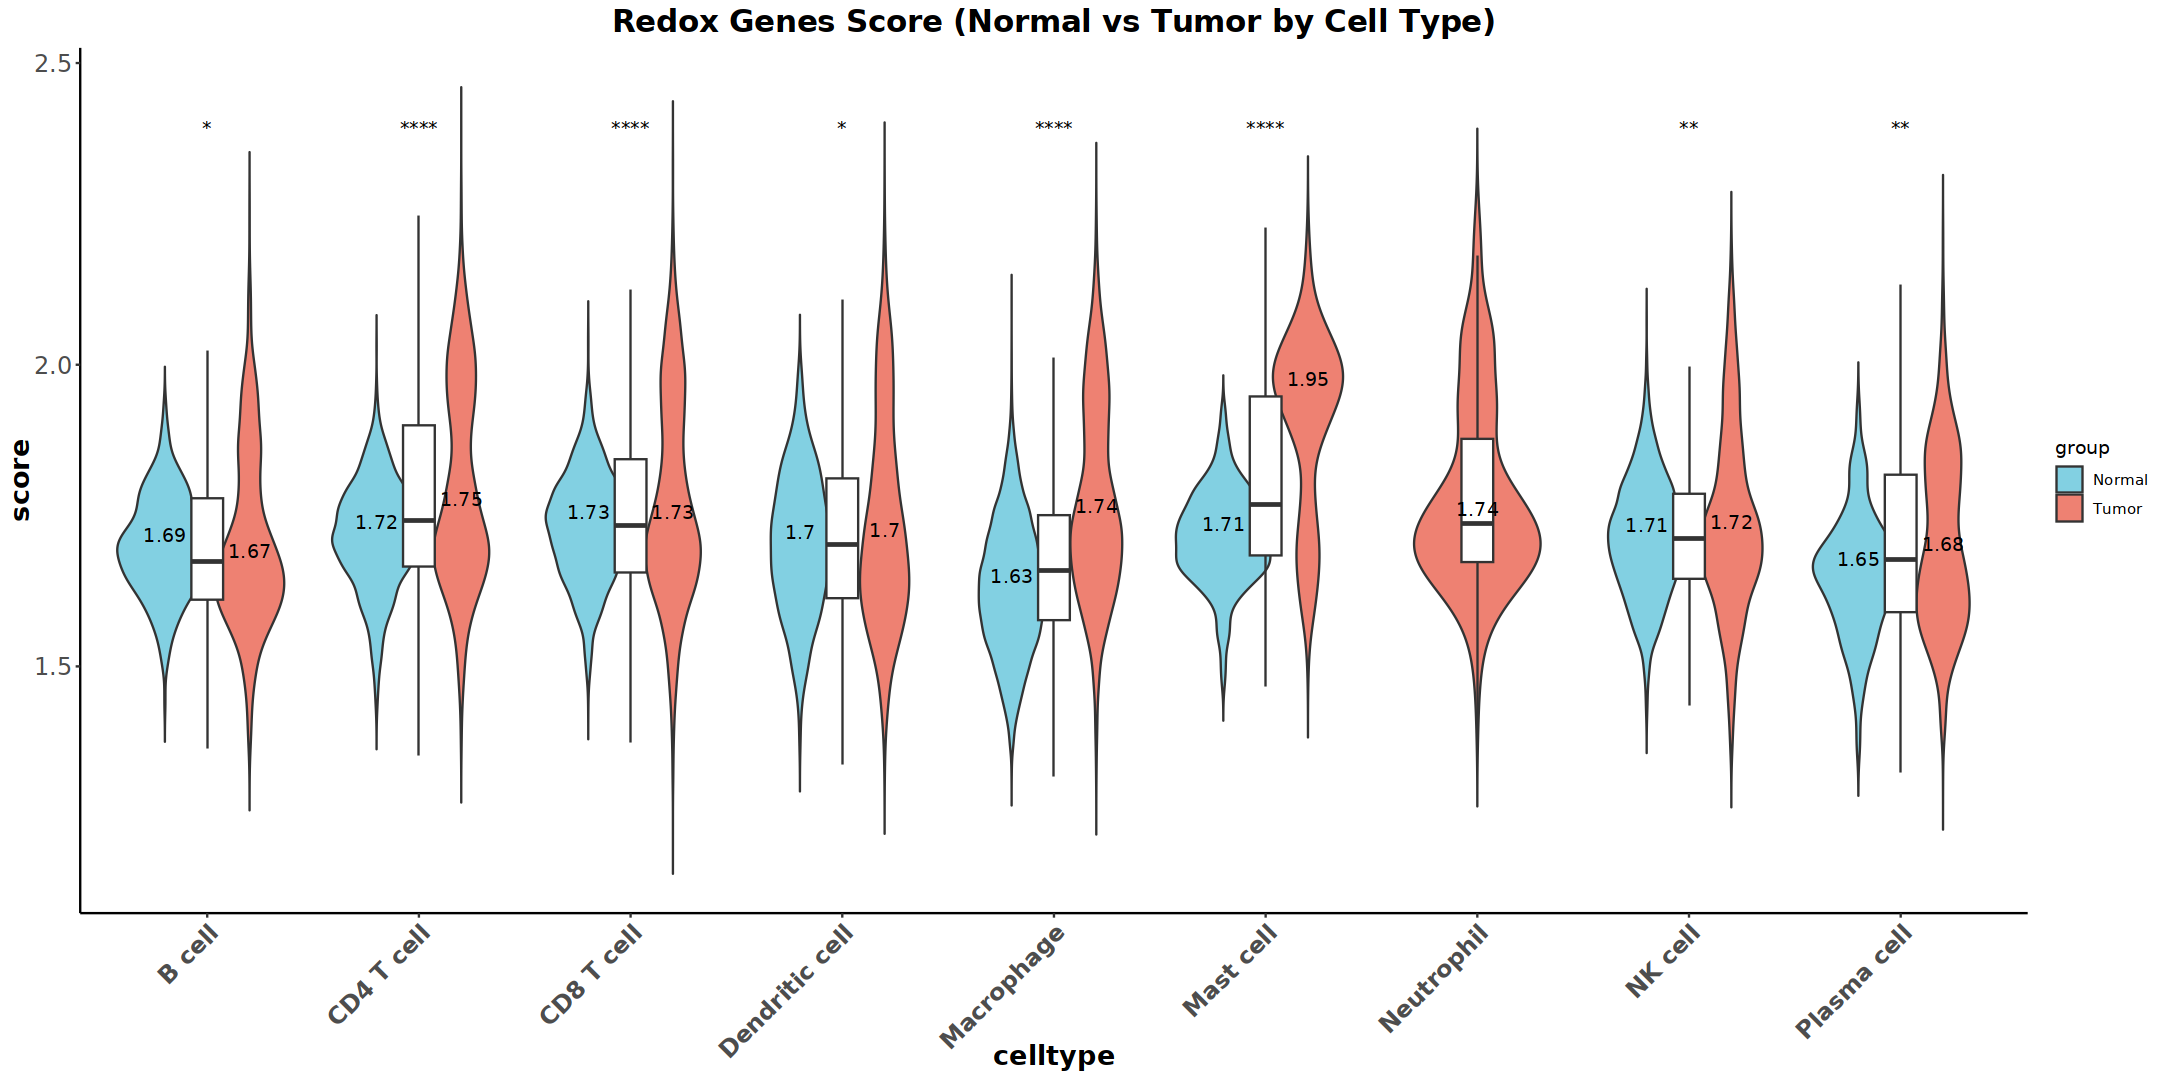

In [17]:
options(repr.plot.width=18, repr.plot.height=9)

library(ggplot2)
library(dplyr)
library(ggpubr)  # 用于添加统计显著性

# 定义配色（每种 celltype 一组颜色，可以分深浅）
celltype_colors <- c(
  "Macrophage"     = "#F38400",
  "Dendritic cell" = "#79C360",
  "Mast cell"      = "#FDB762",
  "CD8 T cell"     = "#E52829",
  "NK cell"        = "#A020F0",
  "B cell"         = "#3F8EAA",
  "Plasma cell"    = "#c7b699",
  "CD4 T cell"     = "#FF90C9",
  "Neutrophil"     = "#A30059"
)

plot_violin_grouped <- function(score_col, title){
  df <- obj@meta.data[, c(score_col, "celltype_big", "type")]
  colnames(df) <- c("score", "celltype", "group")
  df$celltype <- factor(df$celltype, levels = names(table(obj$celltype_big)))
  
  p <- ggplot(df, aes(x = celltype, y = score, fill = group)) +
    geom_violin(trim = FALSE, alpha = 0.7, position = position_dodge(width = 0.8)) +
    geom_boxplot(width = 0.15, outlier.shape = NA, position = position_dodge(width = 0.8), fill = "white") +
    stat_summary(fun = median, geom = "text", aes(label = round(..y..,2), group = group),
                 vjust = -0.5, color = "black", size = 4, position = position_dodge(width = 0.8)) +
    scale_fill_manual(values = c("Normal"="#4DBBD5", "Tumor"="#E64B35")) +
    ggtitle(title) +
    theme_classic() +
    theme(
      plot.title = element_text(hjust = 0.5, face = "bold", size = 18),
      axis.text.x = element_text(angle = 45, hjust = 1, size = 14, face = "bold"),
      axis.text.y = element_text(size = 14),
      axis.title.x = element_text(size = 16, face = "bold"),
      axis.title.y = element_text(size = 16, face = "bold"),
      legend.position = "right"
    ) +
    stat_compare_means(aes(group = group), label = "p.signif", method = "wilcox.test")
  
  return(p)
}

# 绘图
p1 <- plot_violin_grouped("redox_genes", "Redox Genes Score (Normal vs Tumor by Cell Type)")
p2 <- plot_violin_grouped("immune_genes", "Redox Genes Score (Normal vs Tumor by Cell Type)")
print(p1)
print(p2)

# 保存
ggsave("RedoxGenes_VlnPlot_CellType_Compare_Normal_Tumor_0905.png", p1, width = 18, height = 8)
ggsave("immune_genes_VlnPlot_CellType_Compare_Normal_Tumor_0905.png", p2, width = 18, height = 8)

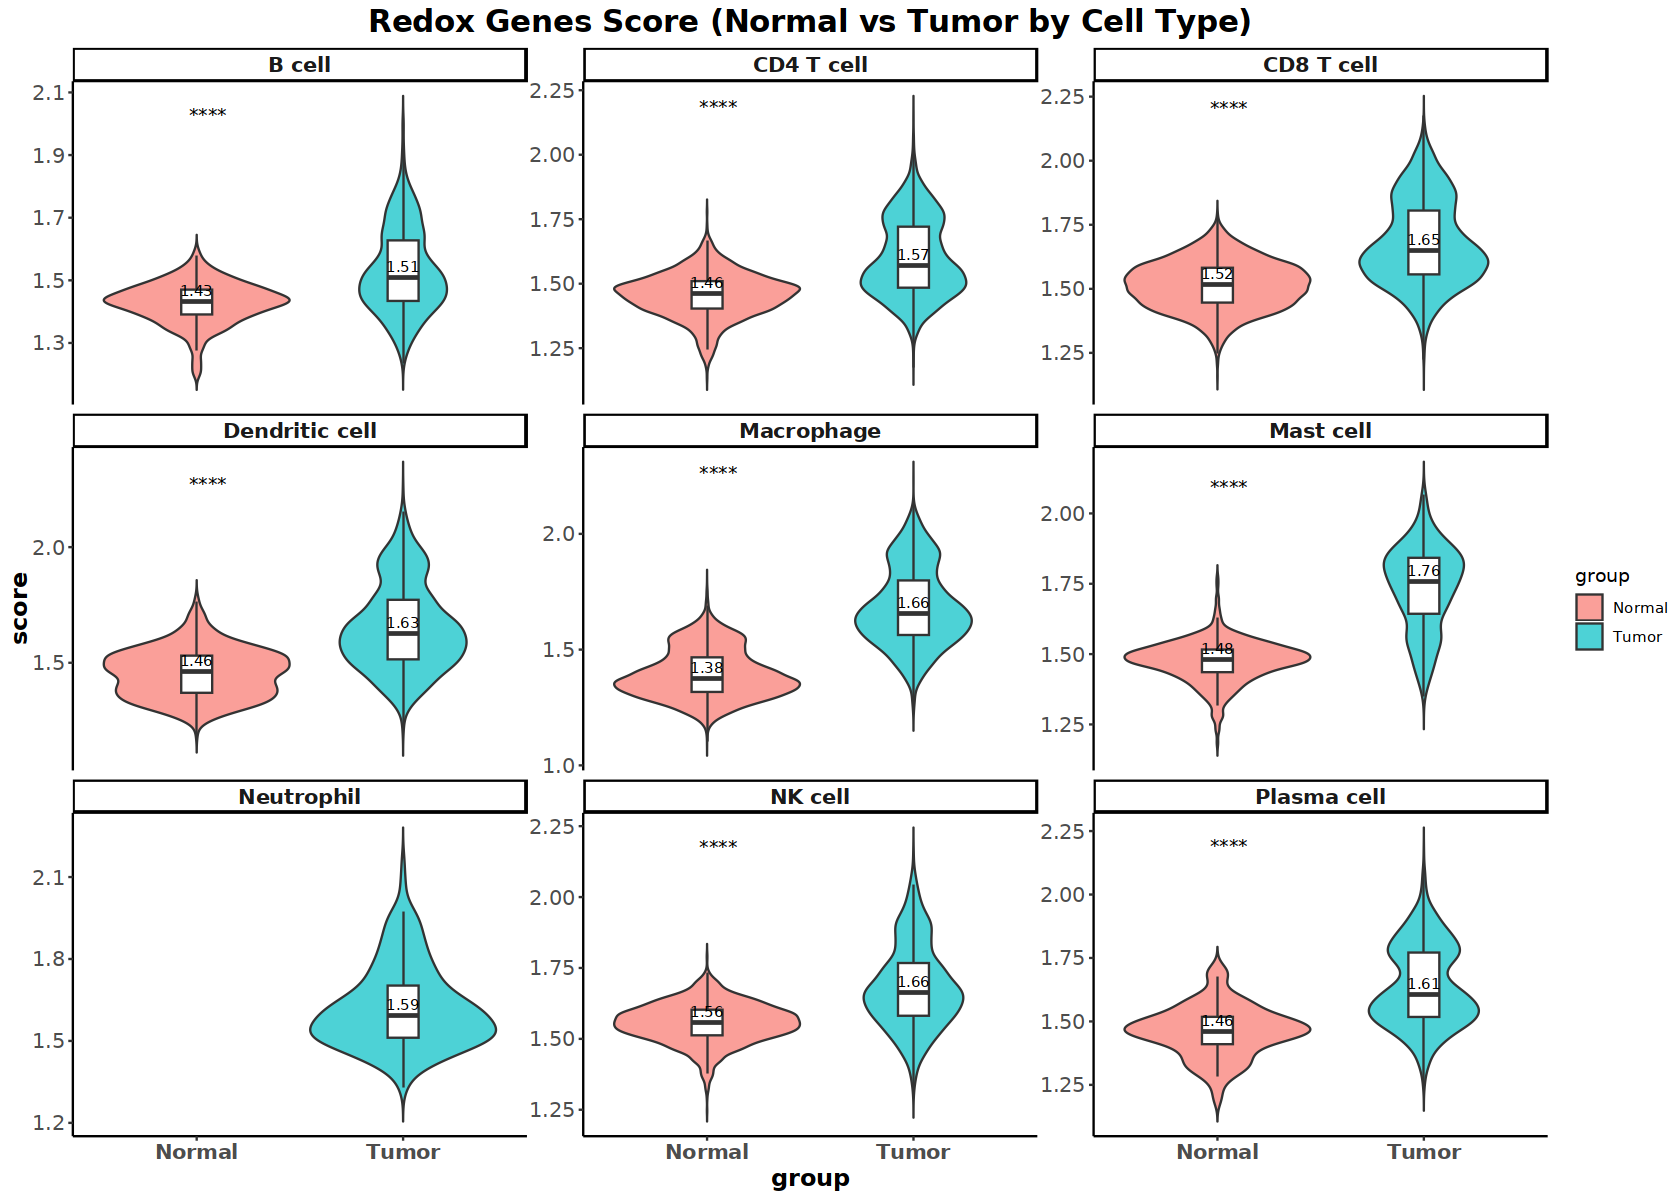

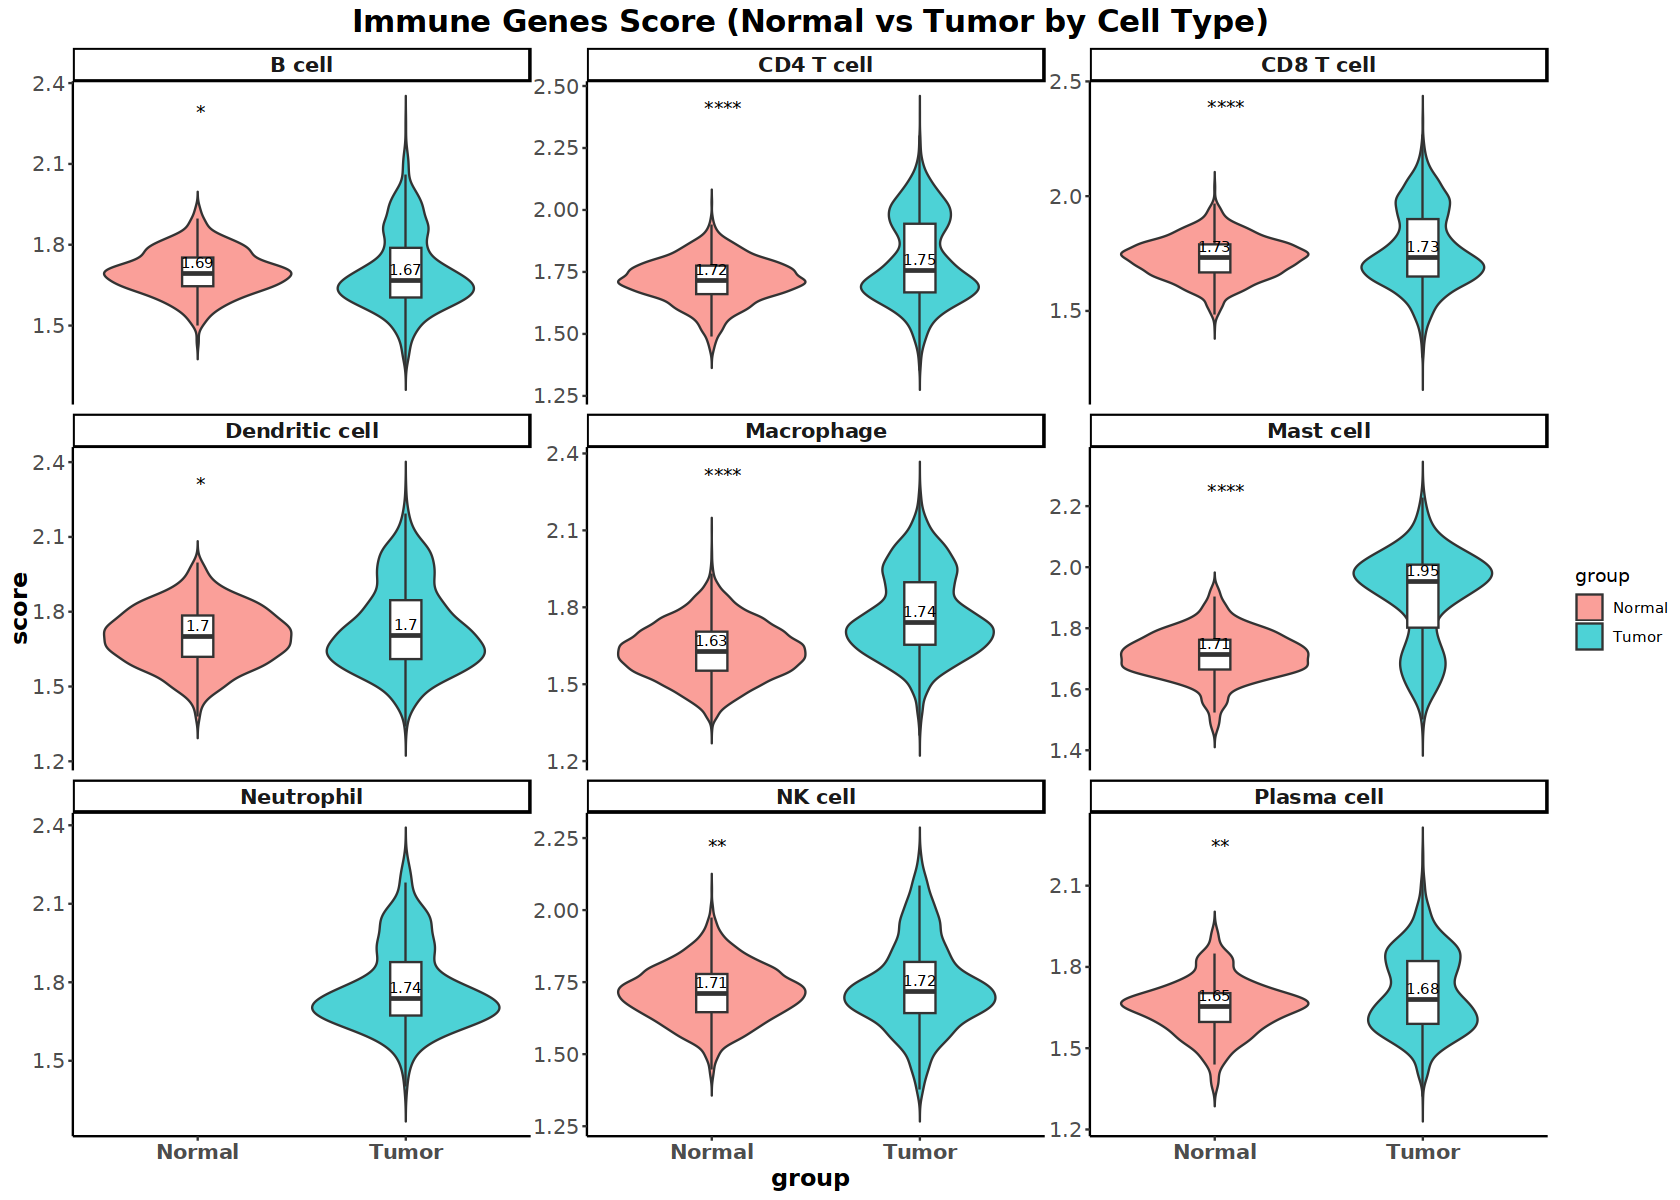

In [22]:
options(repr.plot.width=14, repr.plot.height=10)

library(ggplot2)
library(ggpubr)  # 用于 stat_compare_means

plot_violin_by_group <- function(score_col, title){
  df <- obj@meta.data[, c(score_col, "celltype_big", "type")]
  colnames(df) <- c("score", "celltype", "group")
  df$celltype <- factor(df$celltype, levels = names(table(obj$celltype_big)))
  
  p <- ggplot(df, aes(x = group, y = score, fill = group)) +
    geom_violin(trim = FALSE, alpha = 0.7) +
    geom_boxplot(width = 0.15, outlier.shape = NA, fill = "white") +
    stat_summary(fun = median, geom = "text", aes(label = round(..y..,2)),
                 vjust = -0.5, color = "black", size = 3) +
    facet_wrap(~ celltype, scales = "free_y") +
    stat_compare_means(aes(group = group), method = "wilcox.test", label = "p.signif") +  # 添加统计检验
    ggtitle(title) +
    theme_classic() +
    theme(
      plot.title = element_text(hjust = 0.5, face = "bold", size = 18),
      axis.text.x = element_text(size = 12, face = "bold"),
      axis.text.y = element_text(size = 12),
      axis.title.x = element_text(size = 14, face = "bold"),
      axis.title.y = element_text(size = 14, face = "bold"),
      strip.text = element_text(size = 12, face = "bold")
    )
  
  return(p)
}

# 绘图
p1 <- plot_violin_by_group("redox_genes", "Redox Genes Score (Normal vs Tumor by Cell Type)")
p2 <- plot_violin_by_group("immune_genes", "Immune Genes Score (Normal vs Tumor by Cell Type)")
print(p1)
print(p2)

# 保存
ggsave("RedoxGenes_VlnPlot_CellType_NormalVsTumor_0905.png", p1, width = 14, height = 10)
ggsave("ImmuneGenes_VlnPlot_CellType_NormalVsTumor_0905.png", p2, width = 14, height = 10)

### 2.3 umap plot

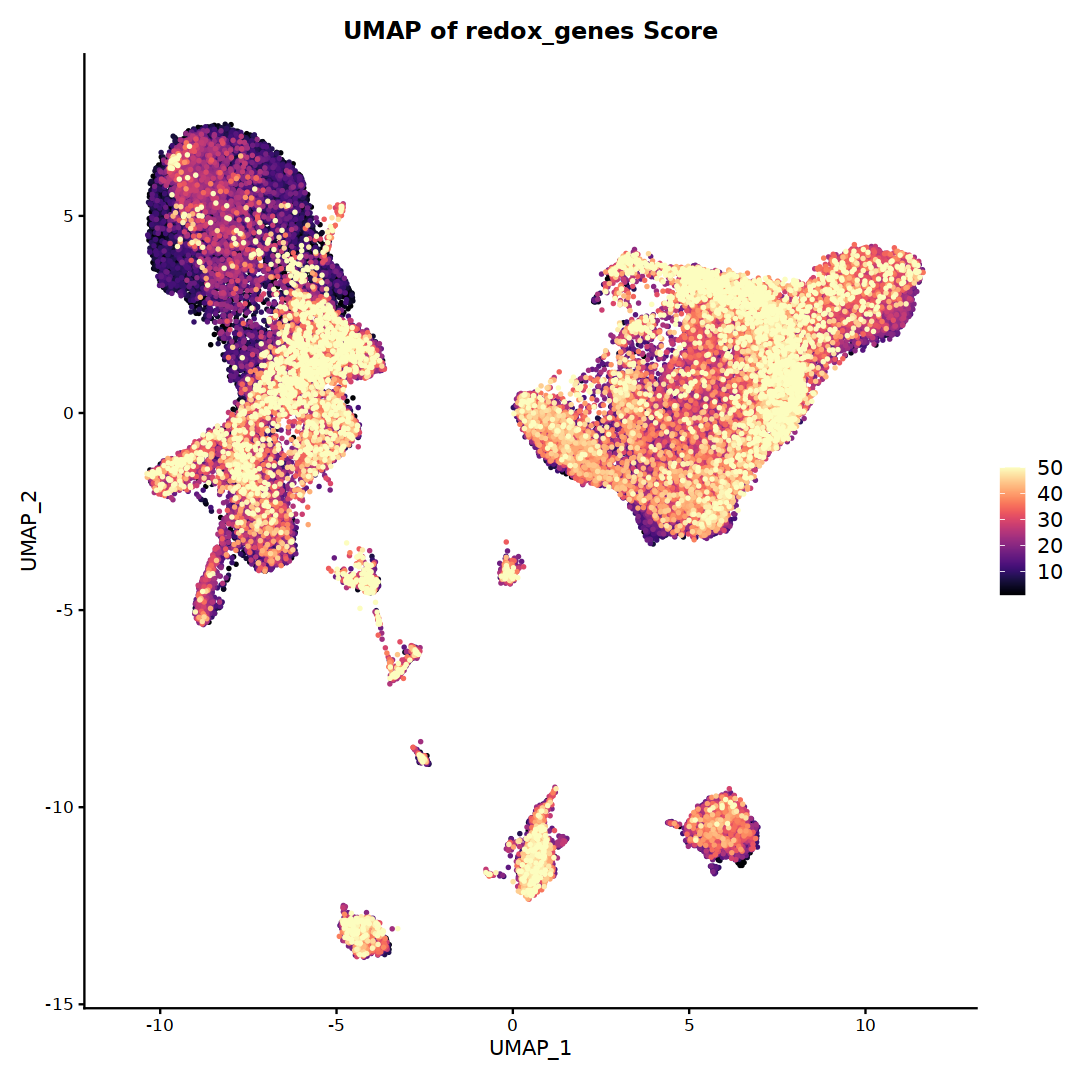

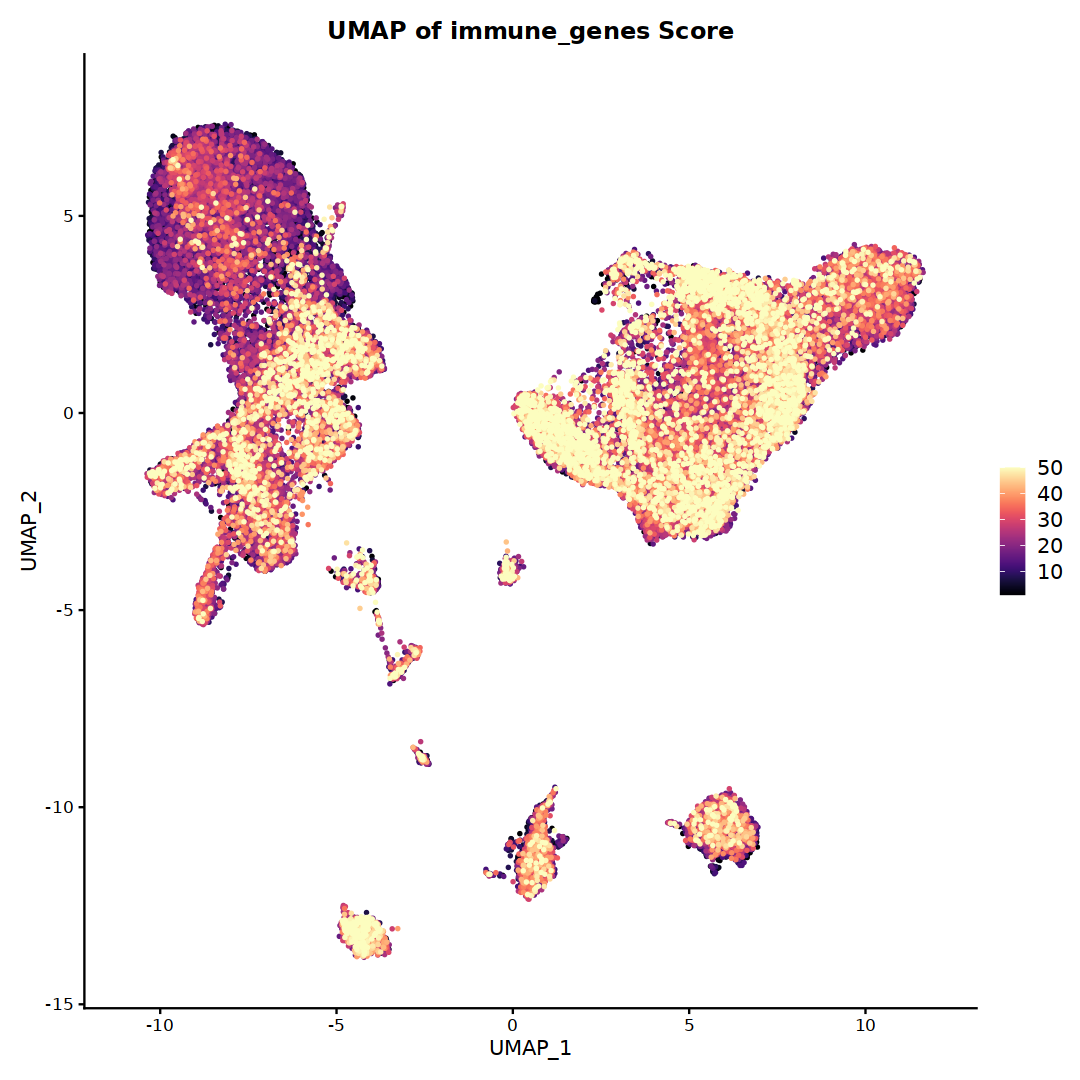

In [23]:
options(repr.plot.width=9, repr.plot.height=9)


# 可视化 redox_genes 通路打分
p1 <- FeaturePlot(
  object = obj,
  features = "redox_genes",
  reduction = "umap",
  pt.size = 0.5,
  order = TRUE,  # 按表达量高低排序，突出高表达细胞
  cols = viridis(50, option = "A"),
  min.cutoff = "q05",  # 5% 分位数作为下限
  max.cutoff = "q95"   # 95% 分位数作为上限，限制极端值
) +
  ggtitle("UMAP of redox_genes Score") +
  theme(plot.title = element_text(hjust = 0.5, face = "bold", size = 14),
        axis.title = element_text(size = 12),
        axis.text = element_text(size = 10))

# 可视化 immune_genes 通路打分
p2 <- FeaturePlot(
  object = obj,
  features = "immune_genes",
  reduction = "umap",
  pt.size = 0.5,
  order = TRUE,
  cols = viridis(50, option = "A"),
  min.cutoff = "q05",
  max.cutoff = "q95"
) +
  ggtitle("UMAP of immune_genes Score") +
  theme(plot.title = element_text(hjust = 0.5, face = "bold", size = 14),
        axis.title = element_text(size = 12),
        axis.text = element_text(size = 10))

# 展示图形
print(p1)
print(p2)


ggsave("redox_genes_umap.png", plot = p1, width = 9, height = 9, dpi = 300, bg = "white")
ggsave("immune_genes_umap.png", plot = p2, width = 9, height = 9, dpi = 300, bg = "white")
ggsave("redox_genes_umap.pdf", plot = p1, width = 9, height = 9)
ggsave("immune_genes_umap.pdf", plot = p2, width = 9, height = 9)